In [117]:
import openmc
import numpy as np
import re
from matplotlib import pyplot as plt

In [118]:
# some constants
thermal_power = 354e6 #watts, J/s
eV_to_J = 1.60218e-19 #joules/eV
average_neutron_energy = 2e6*eV_to_J #J/n, doesn't really matter for heating
neutrons_per_second = thermal_power/average_neutron_energy #n/s
model = openmc.Model.from_model_xml('model.xml')

def lattice_to_xy(lattice_index, pitch):
    #for a y hex lattice
    x = lattice_index[0]*pitch*np.cos(np.deg2rad(30))
    y = 0.5*pitch*lattice_index[0]+pitch*lattice_index[1]

    return (x,y)

/groupspace/cnerg/users/epflug/mambaforge/envs/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/groupspace/cnerg/users/epflug/mambaforge/envs/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/groupspace/cnerg/users/epflug/mambaforge/envs/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/groupspace/cnerg/users/epflug/mambaforge/envs/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=4.
  warn(msg, IDWarning)
/groupspace/cnerg/users/epflug/mambaforge/envs/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=5.
  warn(msg, IDWarning)
/groupspace/cnerg/users/epflug/mambaforge/envs/openmc/l

In [119]:
with openmc.StatePoint('hpc_run_40_4_23.h5') as sp:
    fuel_flux_tally = sp.get_tally(name='Flux')
    fuel_heating_tally = sp.get_tally(name='Heating')
    axial_flux_tally = sp.get_tally(name='Axial Flux Tally')
    runtime = sp.runtime
    particles = sp.n_particles
    batches = sp.n_batches

In [120]:
time = runtime['total']
pps = (particles*batches)/time
pps

13515.958515967832

In [121]:
fuel_flux_mean = fuel_flux_tally.get_reshaped_data('mean')
fuel_flux_stddev = fuel_flux_tally.get_reshaped_data('std_dev')
fuel_flux_rel_err = fuel_flux_stddev/fuel_flux_mean
np.max(fuel_flux_rel_err)

0.11383596436116629

In [122]:
fuel_heating_mean = fuel_heating_tally.get_reshaped_data('mean').flatten() #eV/source
total_heating = np.sum(fuel_heating_mean) #eV/source
fuel_heating_watts = (fuel_heating_mean/total_heating)*thermal_power #percent of total heating/source, or heating per element, watts


fuel_heating_stddev = fuel_heating_tally.get_reshaped_data('std_dev').flatten()
fuel_heating_rel_err = fuel_heating_stddev/fuel_heating_mean
np.max(fuel_heating_rel_err) 

0.0017461287546891413

In [123]:
fuel_heating_watts.max()

735244.1775954625

In [124]:
fuel_heating_mean.shape

(564,)

In [125]:
axial_flux_mean = axial_flux_tally.get_reshaped_data('mean')
axial_flux_stddev = axial_flux_tally.get_reshaped_data('std_dev')
axial_flux_rel_err = axial_flux_stddev/axial_flux_mean
np.max(axial_flux_rel_err)

0.014183879157284161

In [126]:
filters= fuel_heating_tally.filters

In [127]:
dcellfilter = filters[0]

In [128]:
paths = dcellfilter.paths

In [129]:
geometry = model.geometry

In [130]:
geometry.determine_paths()

In [131]:
lattice_indexes = [re.findall(r'\(.*?\)', i) for i in paths]
lattice_indexes = [tuple(map(int, i[0][1:-1].split(','))) for i in lattice_indexes]

In [132]:
points = []

for lattice_index in lattice_indexes:
    points.append(lattice_to_xy(lattice_index, 1.905))

points = np.array(points)

/tmp/ipykernel_2613774/2107902524.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


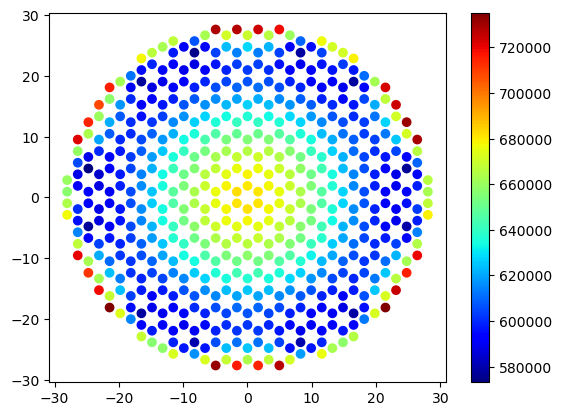

In [133]:
cmap = plt.cm.get_cmap('jet')


bar = plt.scatter(points[:,0],points[:,1], c=fuel_heating_watts, cmap=cmap)
plt.colorbar(bar)